In [3]:
from read_data import *
from hyper import *
from alignment import *
from copy import *
from datasets.preprecossing import *
import rpy2
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster import hierarchy
from math import sin,cos,pi
import scipy 
from sklearn.metrics import adjusted_rand_score

import seaborn as sns
argk = 5
folder_path1 = './datas/test_st1/'
folder_path2 = './datas/test_st2/'

# folder_path2 = './datas/ohss/'
pcanum = 20


In [4]:
folder_path1 = './datas/test_st1/'
cell_path1 = "./datas/nature/151507_preprocessed.h5"


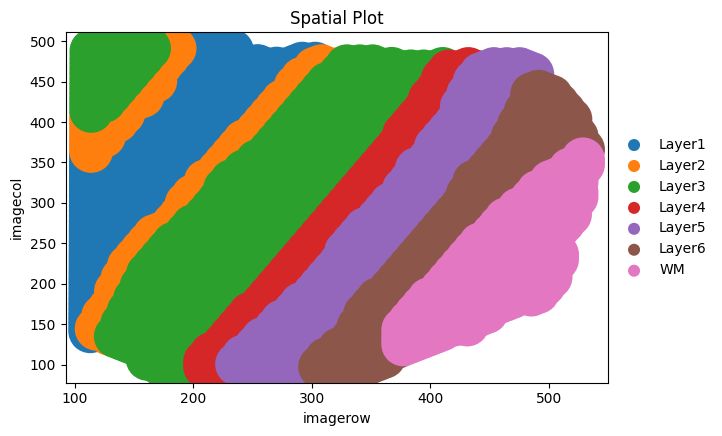

In [5]:
datas = sc.read_h5ad(cell_path1)
sc.pl.scatter(datas,'imagerow', 'imagecol', color='layer_guess_reordered', title='Spatial Plot',size=4000)

In [8]:
count_sub = datas.to_df()
xy_coords = pd.DataFrame(datas.obsm['spatial'],columns=['imagerow','imagecol'],index= datas.obs.index)
xy_coords.to_csv(folder_path1+"xy.csv")
datas.obs.to_csv(folder_path1+'meta_data.csv');
count_sub.T.to_csv(folder_path1+"gene.csv")

In [9]:
# robjects.r("load(paste0('./datas/pca/DLPFC/LIBD_sample1.RData'))")
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects

Spatialpc  = importr('SpatialPCA')
ggplot2 = importr('ggplot2')
scran = importr('scran')
bluster = importr('bluster')
matrix = importr('Matrix')
robjects.r("xy_coords <- read.csv('{}',row.names='X')".format(folder_path1 + 'xy.csv'))
robjects.r("xy_coords=as.matrix(xy_coords)")
robjects.r("count_temp <- read.csv('{}',row.names='X')".format(folder_path1 + 'gene.csv'))
robjects.r('my_matrix <- do.call(cbind, count_temp)')
robjects.r('my_sparse_matrix <- Matrix(my_matrix, sparse = TRUE)')
robjects.r('count_sub <- as(my_sparse_matrix, "dgCMatrix")')
robjects.r('rownames(count_sub) <- rownames(count_temp)')
robjects.r("rownames(xy_coords) = colnames(count_sub)");
robjects.r('LIBD = CreateSpatialPCAObject(counts=count_sub, location=xy_coords, project = "SpatialPCA",gene.type="spatial",sparkversion="spark",numCores_spark=5,gene.number=3000, customGenelist=NULL,min.loctions = 20, min.features=20)')
robjects.r('LIBD = SpatialPCA_buildKernel(LIBD, kerneltype="gaussian", bandwidthtype="SJ",bandwidth.set.by.user=NULL)')
robjects.r('LIBD = SpatialPCA_EstimateLoading(LIBD,fast=FALSE,SpatialPCnum={})'.format(pcanum))
robjects.r('LIBD = SpatialPCA_SpatialPCs(LIBD, fast=FALSE)')
robjects.r('write.csv(as.data.frame(LIBD@SpatialPCs), file = "{}")'.format(folder_path1 + "pca.csv"))
robjects.globalenv.clear()



    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    ## Use SCTransform function in Seurat to normalize data. 


R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 9948 by 4220

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 4220 cells



  |======================================================================| 100%


R[write to console]: Found 37 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 9948 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 9948 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 58.56347 secs

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=====                                                                 |   7%
  |                                                                            
  |==========                                                            |  14%
  |                                                                            
  |===============                                                       |  21%
  |                                                                         

## Use spark.test function in SPARK package to select spatially variable genes. 
## ===== SPARK INPUT INFORMATION ==== 
## number of total samples:  4220 
## number of total features:  3969 
## number of adjusted covariates:  0 
# fitting normalized count-based spatial model under the null hypothesis ... 
## testing Gaussian kernel: 1...
## testing Periodic kernel: 1...
## testing Gaussian kernel: 2...
## testing Periodic kernel: 2...
## testing Gaussian kernel: 3...
## testing Periodic kernel: 3...
## testing Gaussian kernel: 4...
## testing Periodic kernel: 4...
## testing Gaussian kernel: 5...
## testing Periodic kernel: 5...
## Identified  1290  spatial genes through spark.test function. 
The  number of significant spatial genes is less than the specified number of spatial genes. 
## Using  1290  significant spatially variable genes. 
## Selected kernel type is:  gaussian  
## The bandwidth is:  0.0396964277485742  
## Calculating kernel matrix
## Finished calculating kernel matrix

NameError: name 'folder_path' is not defined

In [14]:
adata1 = pd.read_csv(folder_path1 + 'pca.csv')
adata1 = adata1.set_index(adata1.columns[0])
adata1 = adata1.T
adata1.index = datas.obs.layer_guess_reordered
adata1.T.to_csv(folder_path1+'annT.csv',index=None)


In [16]:
args=[ i+1 for i in range(40,60)];
steps = [i+1 for i in range(3,6)];
anss = [];
ansss = [];
for argk in args:
    for step in steps:
        matrix = importr('Matrix')
        # igraph = importr('igraph')
        robjects.r("library('igraph')")
        robjects.r(" xys <- read.csv('{}')".format(folder_path1+'annT.csv'));
        robjects.r("g <- buildSNNGraph(xys,k={})".format(argk))
        robjects.r("walktrap <- walktrap.community(g,steps={})".format(step))
        robjects.r("clusters <- membership(walktrap)")
        robjects.r("write.csv(clusters,file='{}')".format(folder_path1+'cluster.csv'))
        robjects.globalenv.clear()
        meta1 = pd.read_csv(folder_path1+'cluster.csv')
        meta1 = meta1.set_index(meta1.columns[0])
        meta1['x'].tolist()
        ari = adjusted_rand_score(meta1['x'].tolist(), datas.obs['layer_guess_reordered'].tolist())
        print("ARI score for {},{}: ".format(argk,step), ari)
        # datas.obs['julei']= meta1['x'].tolist()
        # sc.pl.scatter(datas,'imagerow', 'imagecol', color='julei', title='Spatial Plot',size=4000)
        anss.append(ari)
        ansss.append(meta1['x'].tolist())

ARI score for 41,4:  0.5195563384292301
ARI score for 41,5:  0.45711055794051614
ARI score for 41,6:  0.4854514792947798
ARI score for 42,4:  0.4911478398033158
ARI score for 42,5:  0.46974661811701207
ARI score for 42,6:  0.45349200082979757
ARI score for 43,4:  0.4905900105531496
ARI score for 43,5:  0.527969789343221
ARI score for 43,6:  0.4603296480033083
ARI score for 44,4:  0.45568449907134123
ARI score for 44,5:  0.5319380383557754
ARI score for 44,6:  0.507686214393468
ARI score for 45,4:  0.5047889305243143
ARI score for 45,5:  0.5322727646550162
ARI score for 45,6:  0.4915651885337079
ARI score for 46,4:  0.5119316212584427
ARI score for 46,5:  0.5094976339264607
ARI score for 46,6:  0.586185191365249
ARI score for 47,4:  0.46426660842770245
ARI score for 47,5:  0.4599601491631901
ARI score for 47,6:  0.5253666897415854
ARI score for 48,4:  0.4917016891285319
ARI score for 48,5:  0.4988259461814468
ARI score for 48,6:  0.4646173052384615
ARI score for 49,4:  0.511450721475563

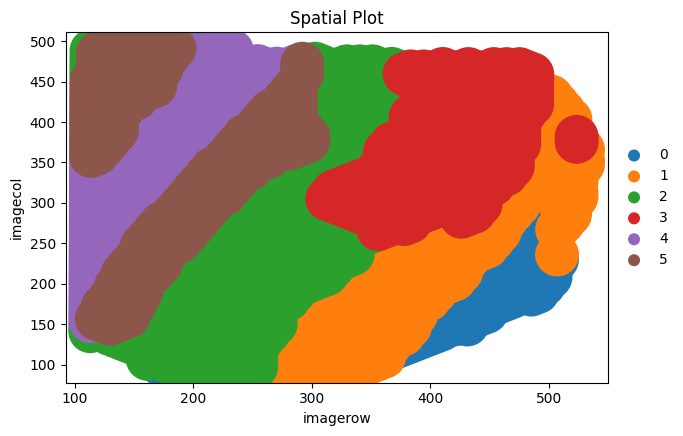

In [17]:
indexss= anss.index(np.array(anss).max())
datas.obs['julei']= (np.array(ansss[indexss])-1).astype('str')
sc.pl.scatter(datas,'imagerow', 'imagecol', color='julei', title='Spatial Plot',size=4000)
np.save(folder_path1+'cluster.npy',(np.array(ansss[indexss])-1).astype('str'))

./datas/test_st1/datas.data length:6
Generating all pairs superset


100%|██████████| 1563/1563 [01:03<00:00, 24.70ex/s, loss=0.866547] 


	 Epoch 0 | average train loss: 0.829975
Optimization finished.


100%|██████████| 1563/1563 [01:00<00:00, 25.70ex/s, loss=0.847504] 


	 Epoch 1 | average train loss: 0.826392
Optimization finished.


100%|██████████| 1563/1563 [01:09<00:00, 22.35ex/s, loss=0.690710] 


	 Epoch 2 | average train loss: 0.826917
Optimization finished.


100%|██████████| 1563/1563 [01:02<00:00, 24.96ex/s, loss=0.800843] 


	 Epoch 3 | average train loss: 0.820924
Optimization finished.


100%|██████████| 1563/1563 [00:59<00:00, 26.28ex/s, loss=0.967544] 


	 Epoch 4 | average train loss: 0.820017
Optimization finished.


100%|██████████| 1563/1563 [01:01<00:00, 25.40ex/s, loss=0.950758] 


	 Epoch 5 | average train loss: 0.819743
Optimization finished.


100%|██████████| 1563/1563 [01:00<00:00, 25.93ex/s, loss=0.718284] 


	 Epoch 6 | average train loss: 0.818812
Optimization finished.


100%|██████████| 1563/1563 [00:59<00:00, 26.17ex/s, loss=0.785771] 


	 Epoch 7 | average train loss: 0.818300
Optimization finished.


100%|██████████| 1563/1563 [00:59<00:00, 26.18ex/s, loss=0.914916] 


	 Epoch 8 | average train loss: 0.818802
Optimization finished.


100%|██████████| 1563/1563 [01:00<00:00, 26.04ex/s, loss=0.655958] 


	 Epoch 9 | average train loss: 0.816449
Optimization finished.


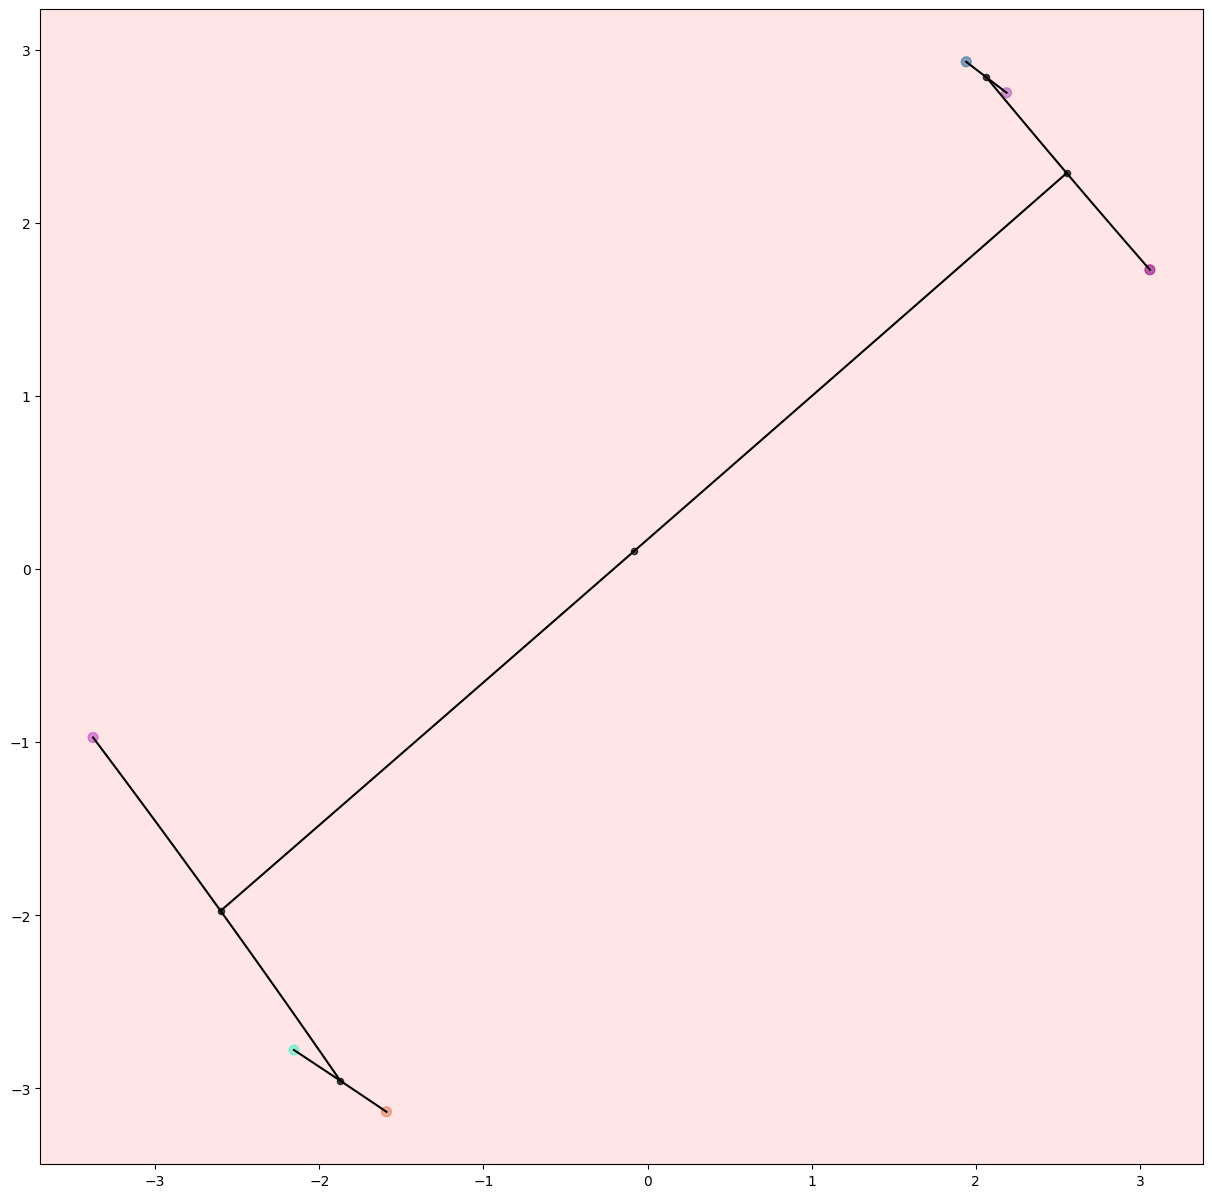

In [18]:
adata1.index = ansss[indexss]
adata1.groupby(adata1.index).mean()
adata1.groupby(adata1.index).mean().to_csv(folder_path1+"datas.data",header=None);
adata1.groupby(adata1.index).mean().to_csv(folder_path1+"datas.csv");
get_Hyper_tree(folder_path1+'datas.data',1,adata1.groupby(adata1.index).mean().shape[1]+1,0,10,model_path=None,save_path=folder_path1,c=-1)
